In [1]:
import os
from nuscenes import NuScenes
from jupyterthemes import jtplot
import matplotlib.pyplot as plt

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/'.join(os.path.abspath(os.curdir).split('/')[:-2])
DATAROOT = os.path.join(DATAROOT, 'data/sets/nuscenes')

nusc = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.380 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
from nuscenes.prediction import PredictHelper
helper = PredictHelper(nusc)

In [3]:
sensor_channels = [sensor['channel'] for sensor in nusc.sensor]
sensor_channels

['CAM_FRONT',
 'CAM_BACK',
 'CAM_BACK_LEFT',
 'CAM_FRONT_LEFT',
 'CAM_FRONT_RIGHT',
 'CAM_BACK_RIGHT',
 'LIDAR_TOP',
 'RADAR_FRONT',
 'RADAR_FRONT_RIGHT',
 'RADAR_FRONT_LEFT',
 'RADAR_BACK_LEFT',
 'RADAR_BACK_RIGHT']

In [64]:
import math
import numpy as np

def euler_from_quaternion(w, x, y, z):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians
    

def global_to_local(ego_trans, ego_rot_quaternion, global_locations):
    x,y,z = ego_trans    
    _, _, yaw = euler_from_quaternion(*ego_rot_quaternion)      
    cy = math.cos(yaw) 
    sy = math.sin(yaw)
    
    mat = np.array([[sy, -cy, 0, -x*sy + y*cy],
                    [cy, sy, 0, -x*cy - y*sy],
                    [0, 0, 1, -z],
                    [0, 0, 0, 1]])
    global_locations = global_locations.T 
    
    global_locations = np.vstack([global_locations,
                                  np.zeros_like(global_locations[0]), 
                                  np.ones_like(global_locations[0])])
    local_locations = np.matmul(mat, global_locations)
    return local_locations[:2]

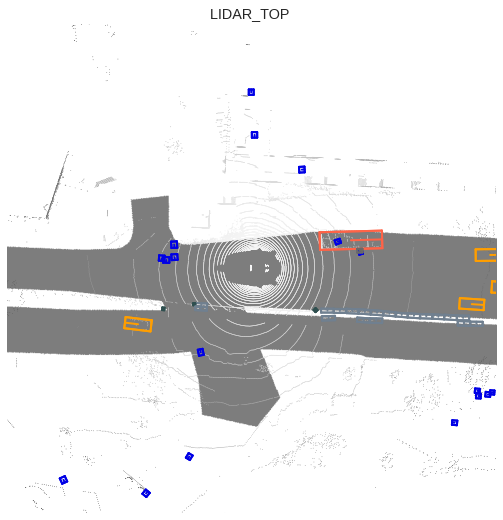

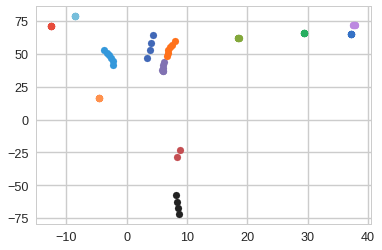

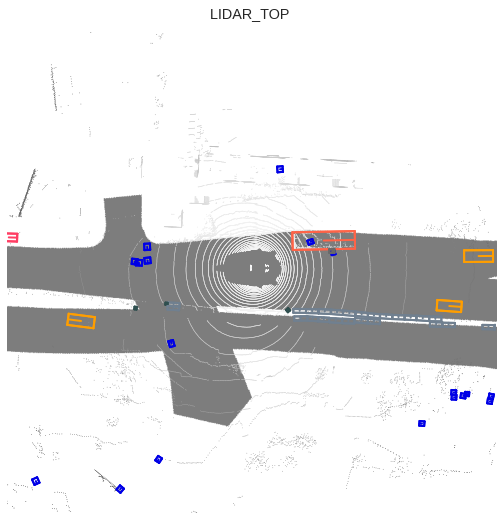

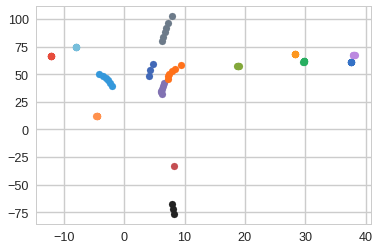

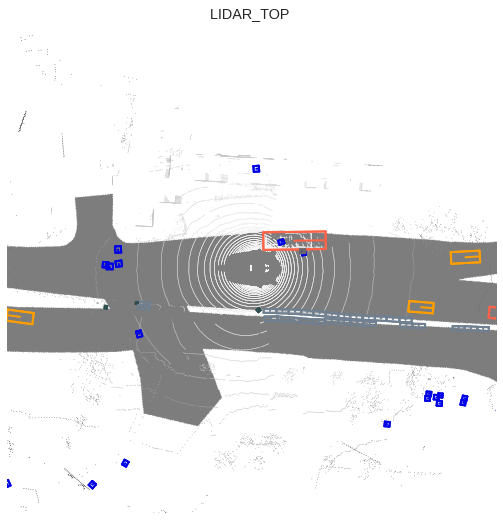

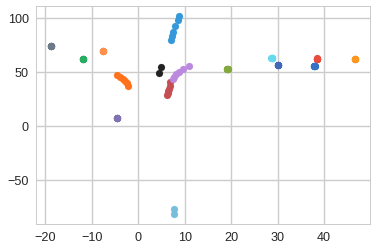

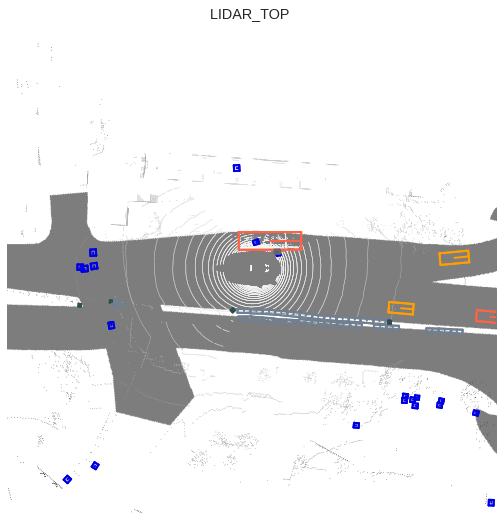

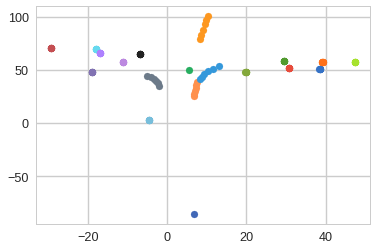

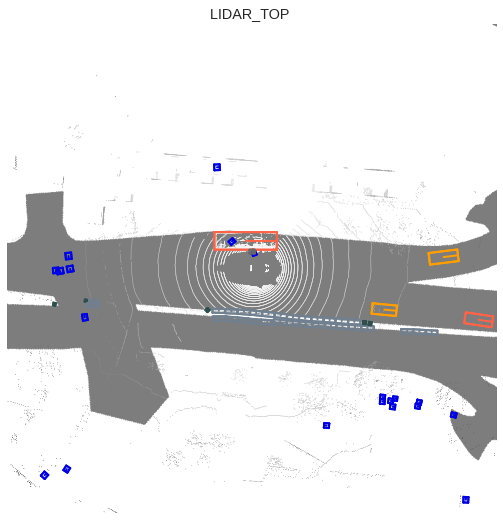

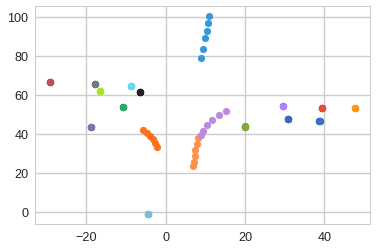

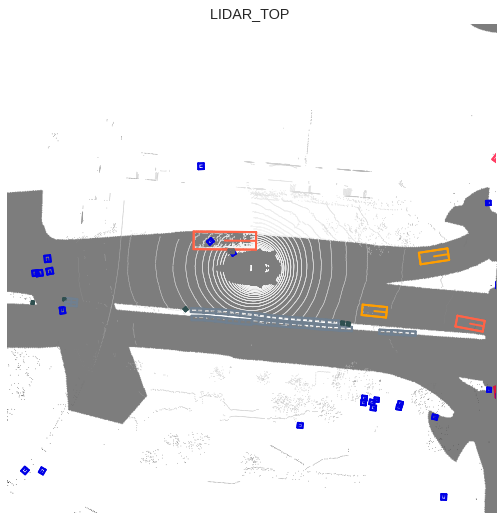

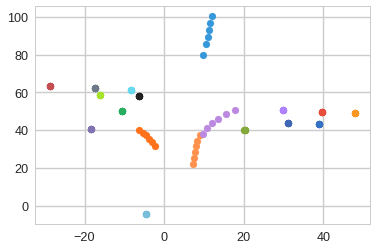

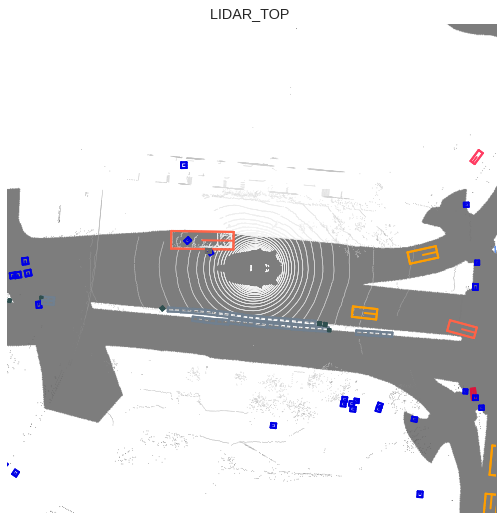

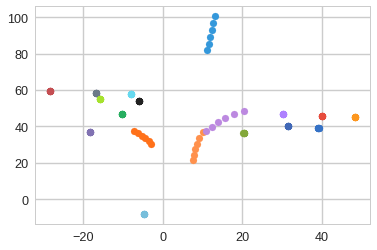

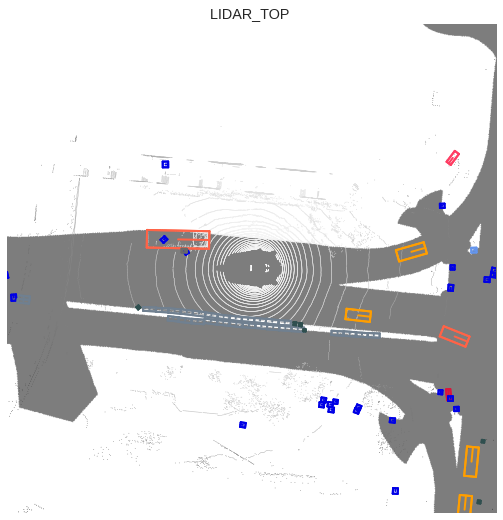

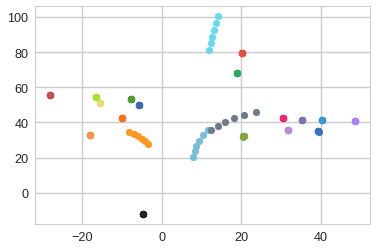

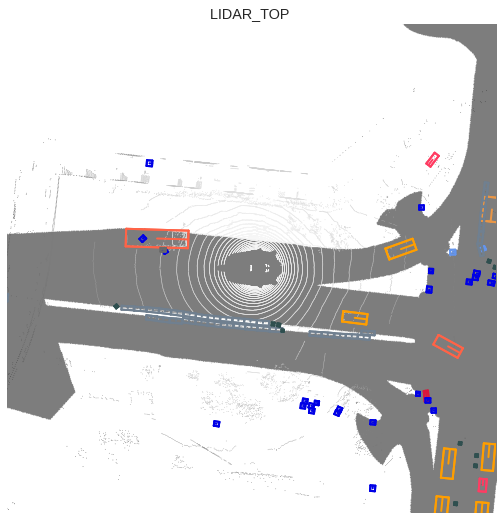

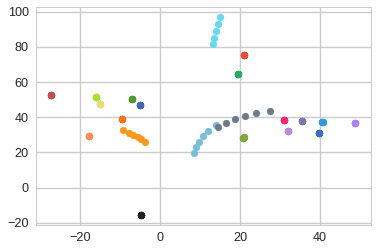

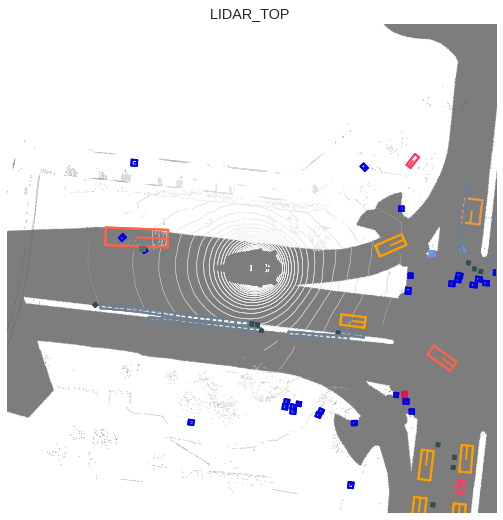

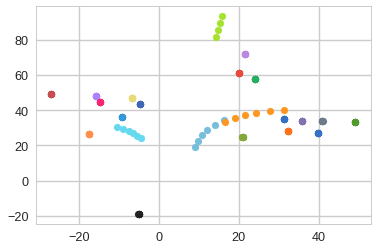

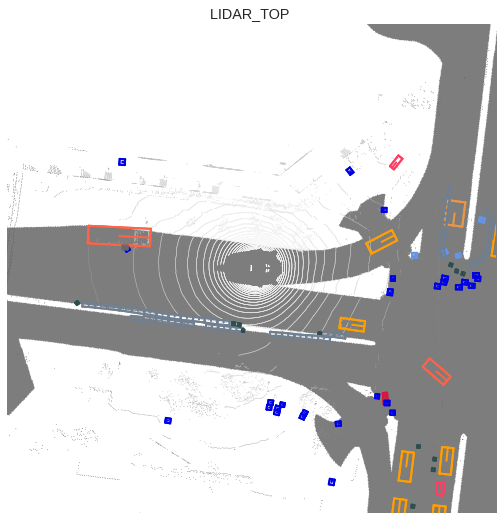

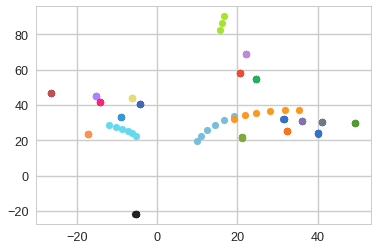

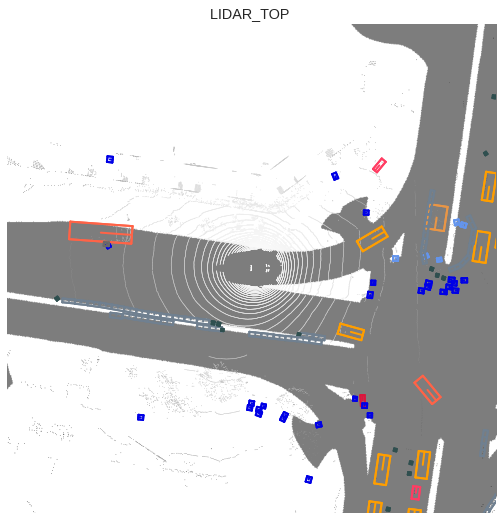

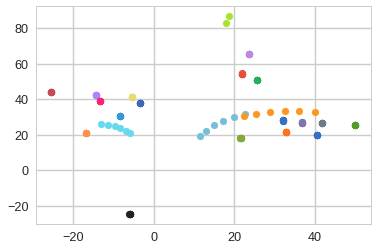

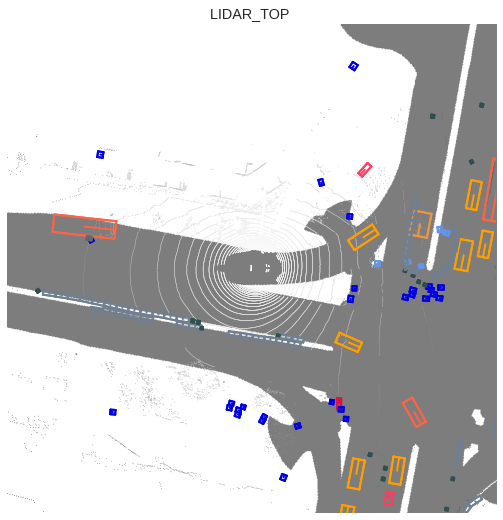

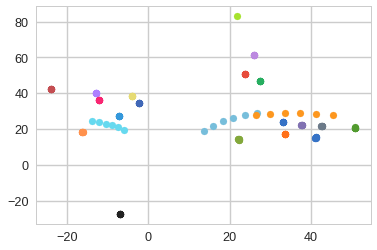

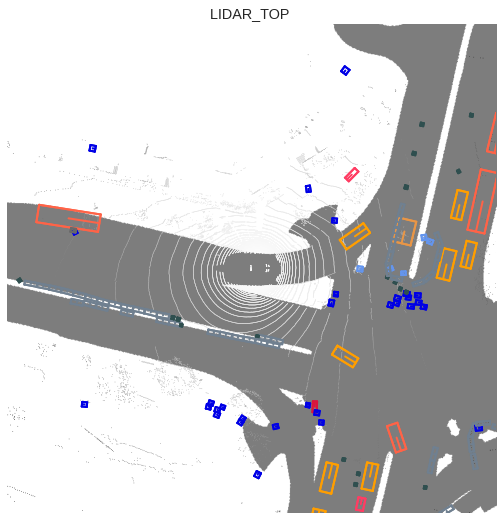

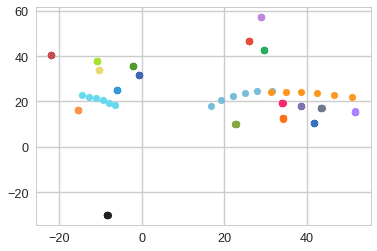

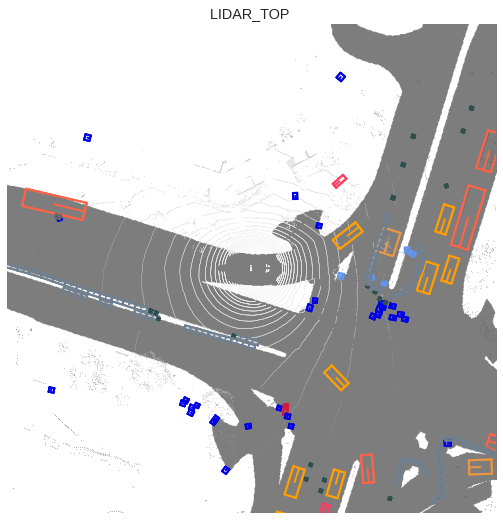

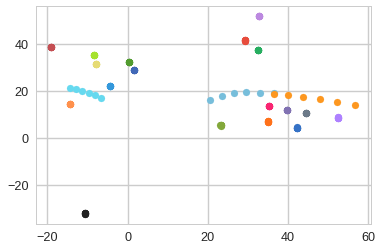

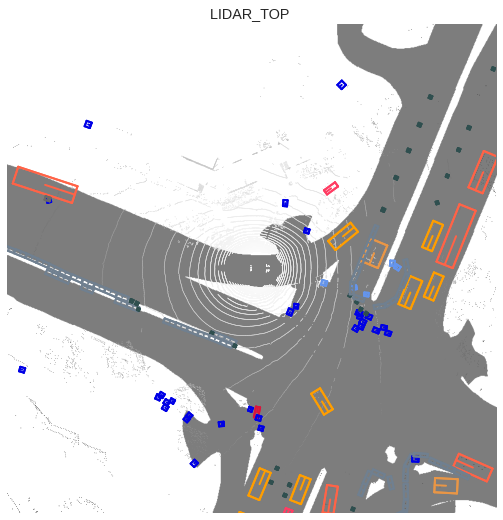

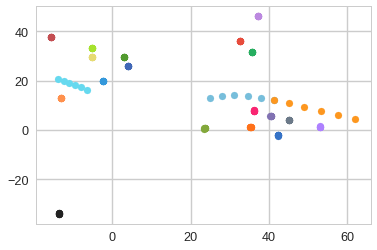

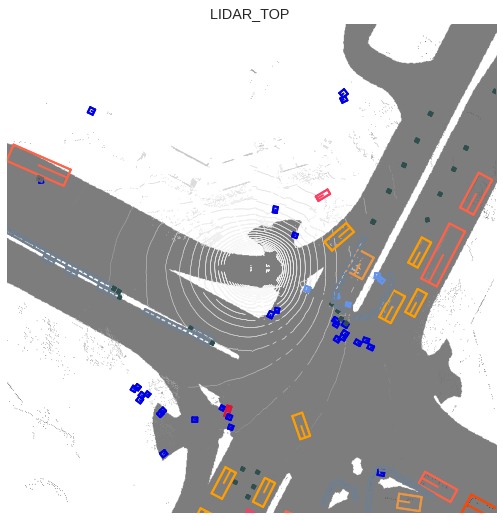

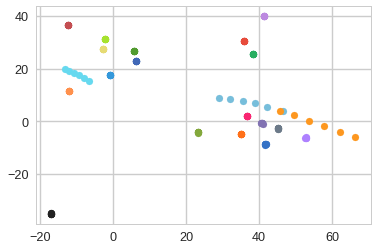

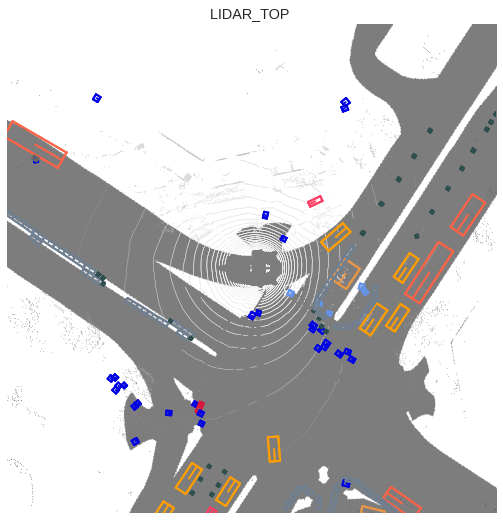

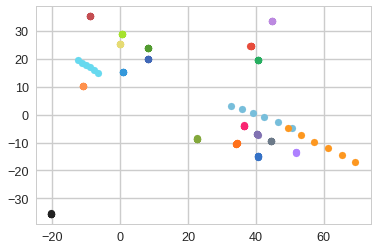

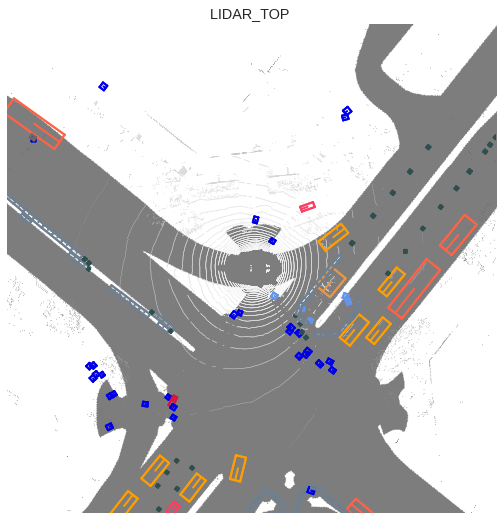

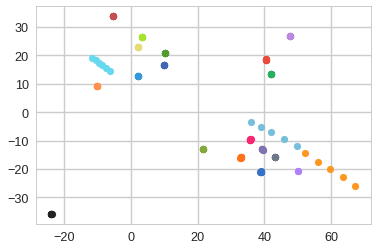

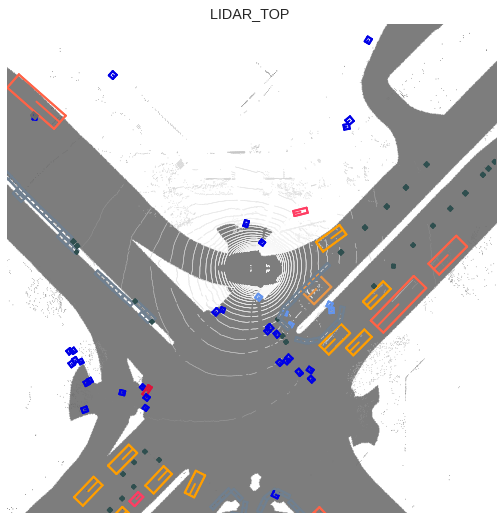

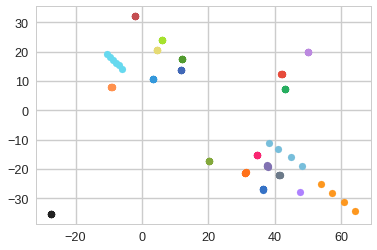

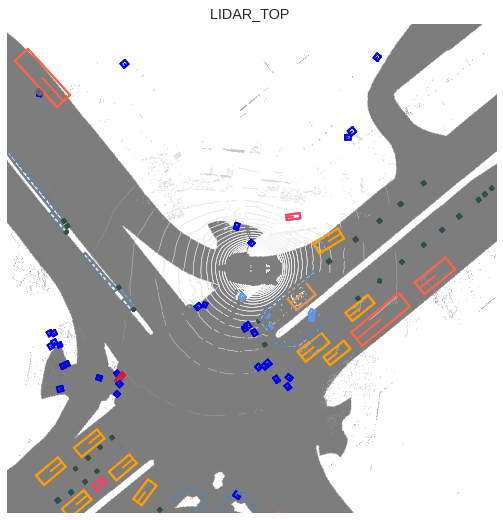

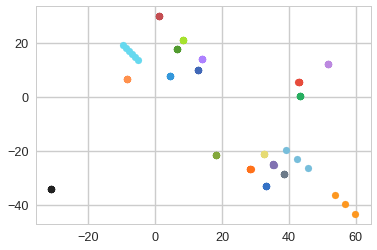

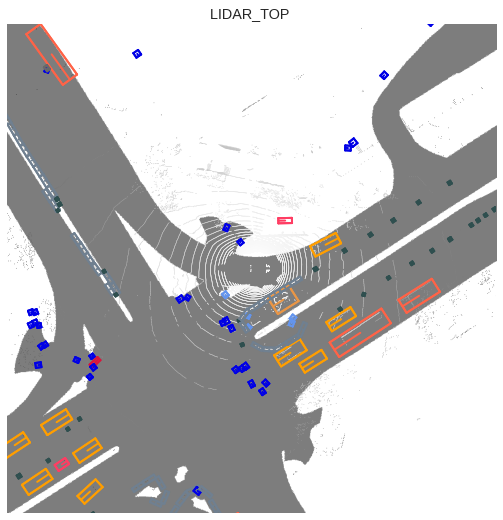

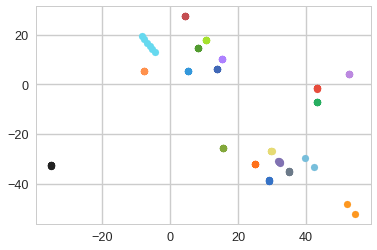

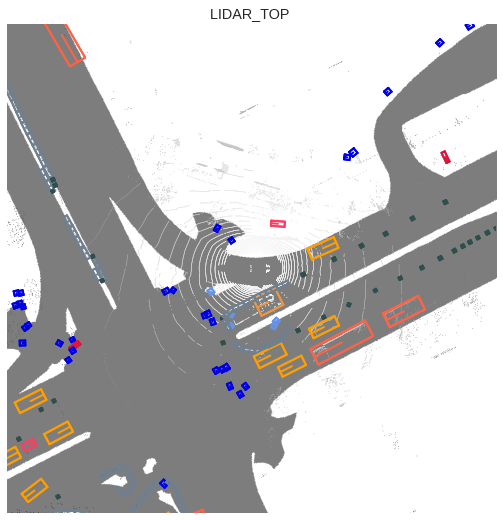

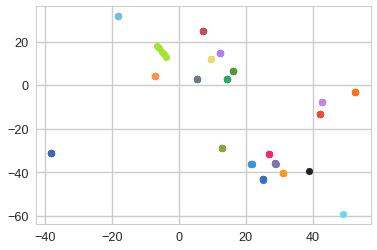

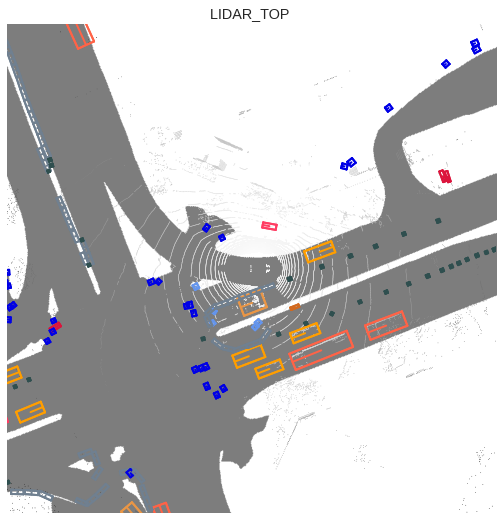

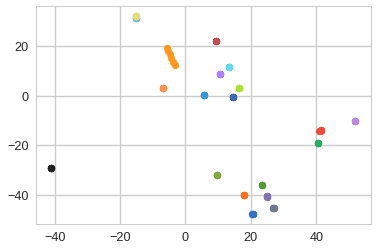

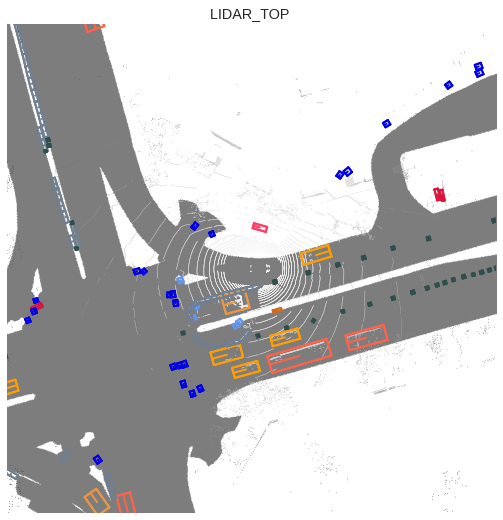

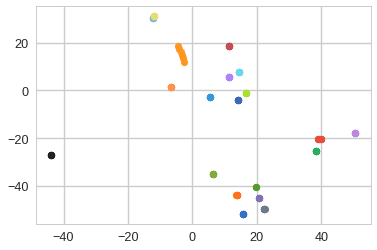

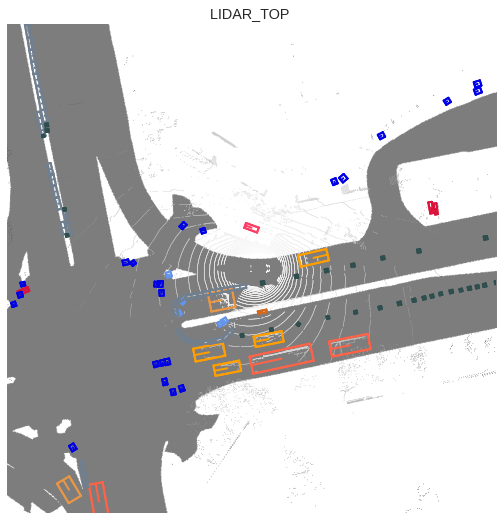

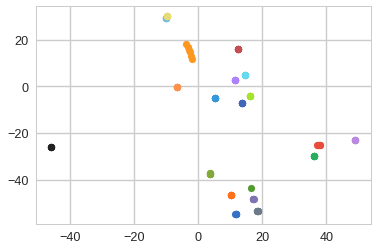

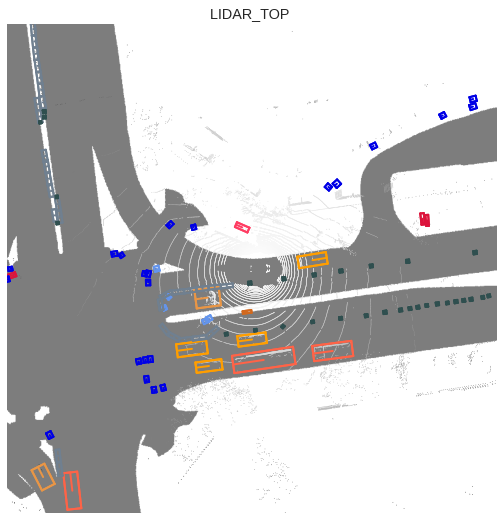

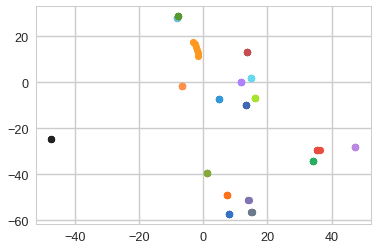

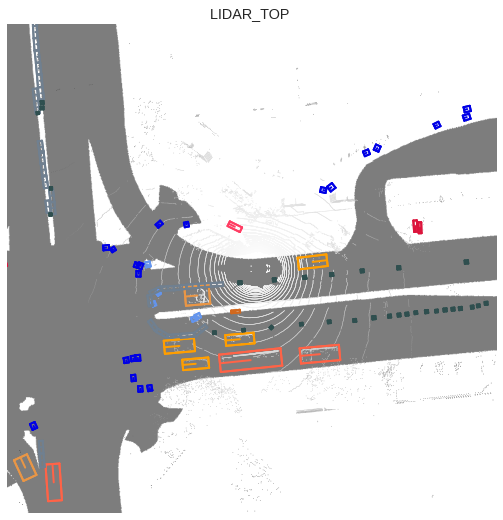

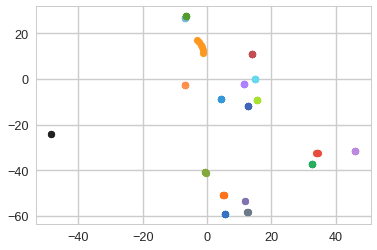

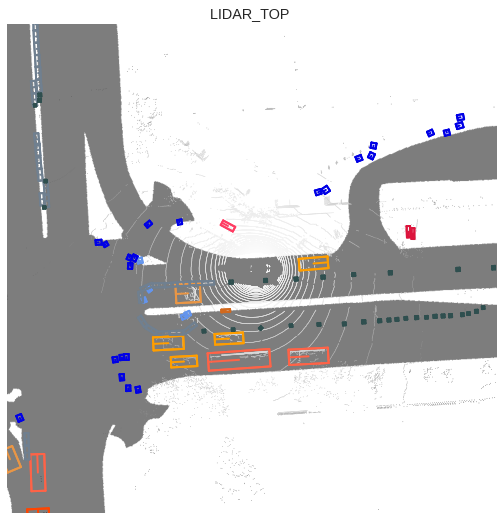

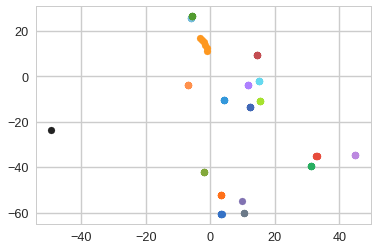

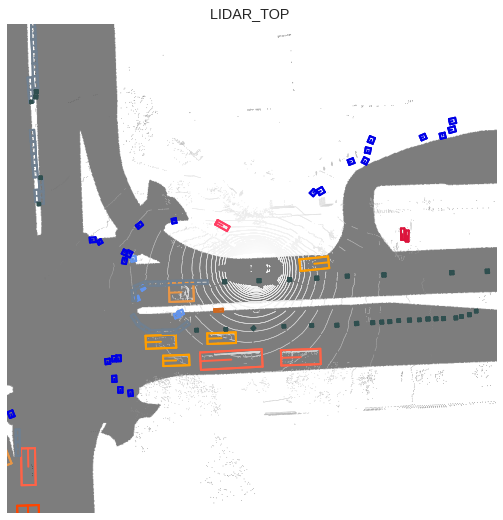

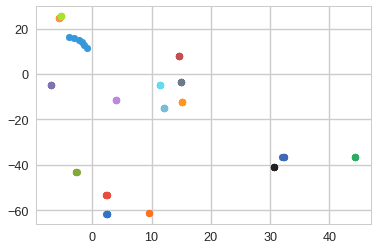

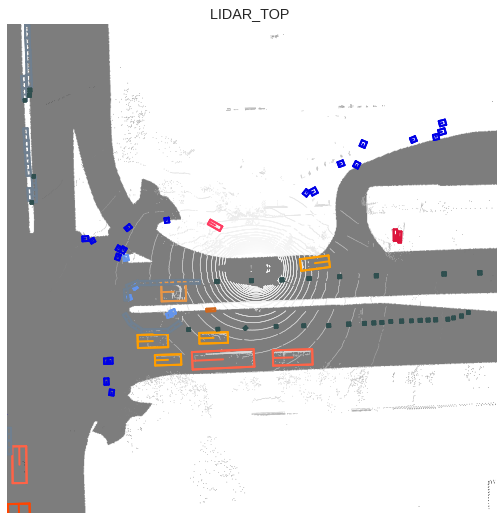

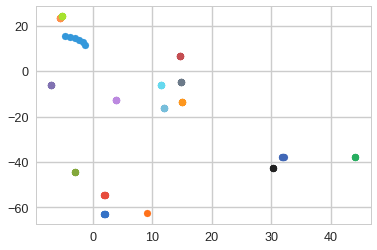

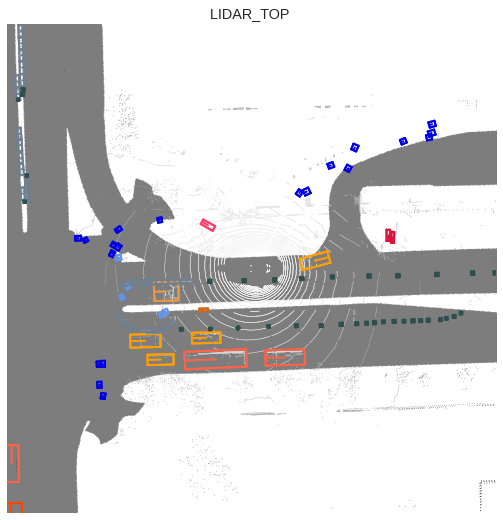

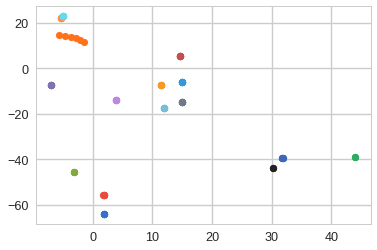

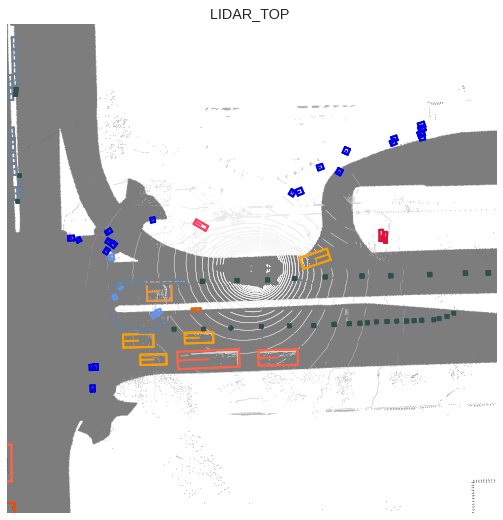

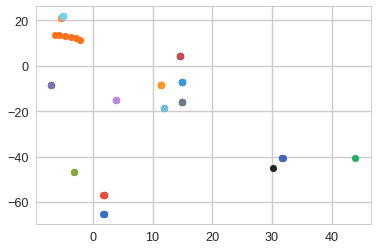

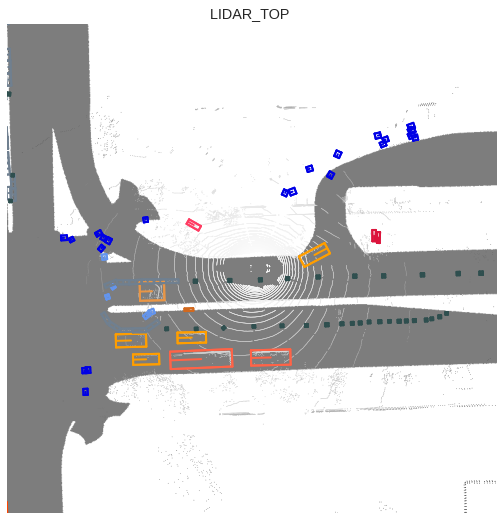

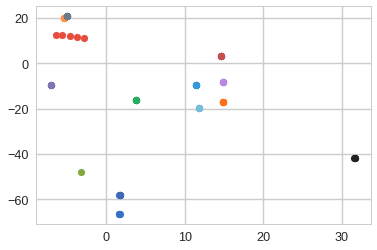

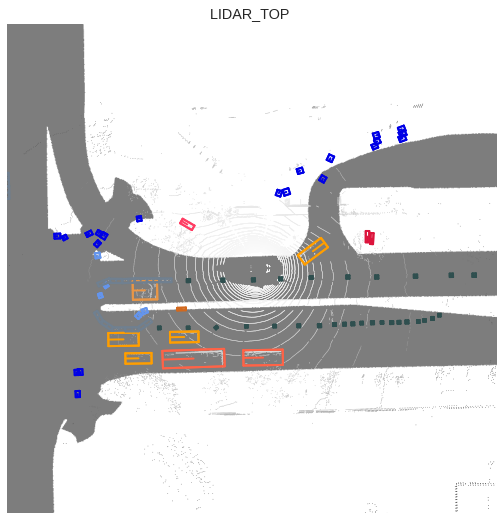

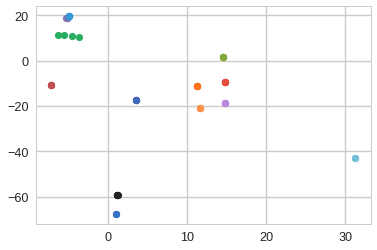

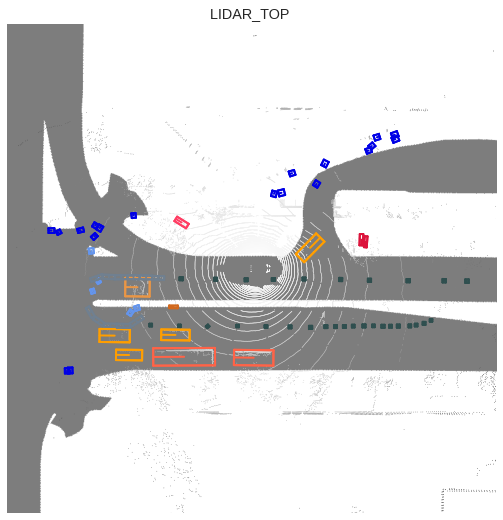

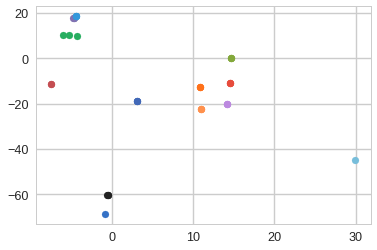

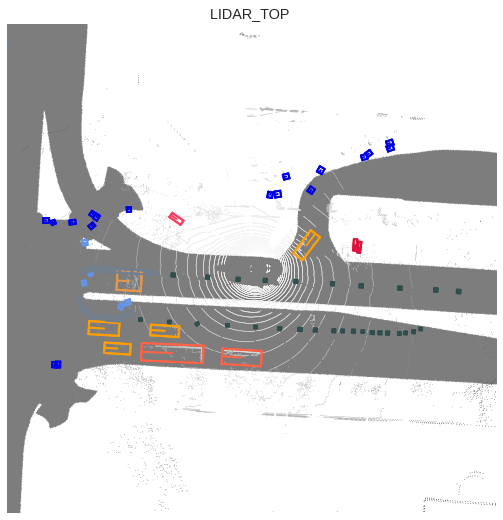

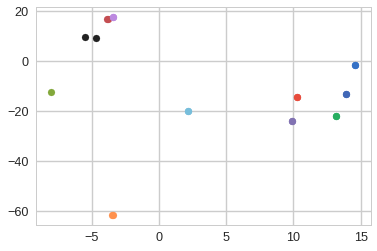

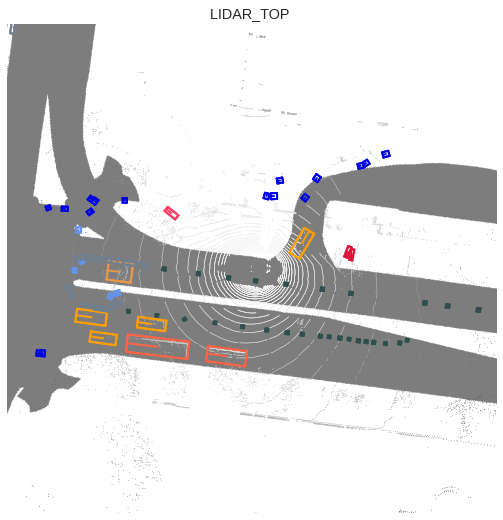

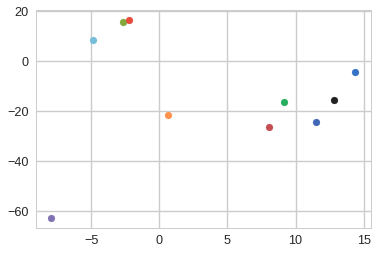

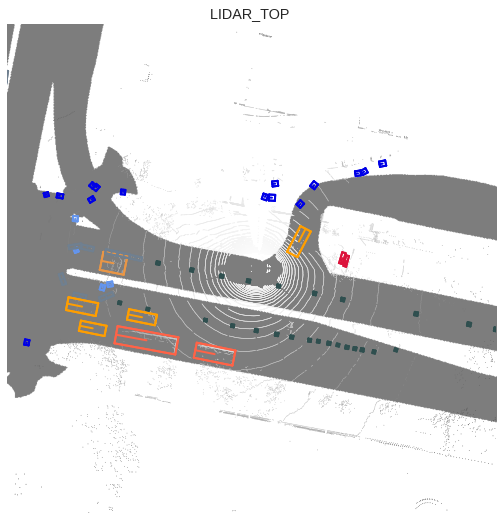

In [158]:
scene_idx = 0
current_sample_token = nusc.scene[scene_idx]['first_sample_token']
current_sample = nusc.get('sample', current_sample_token)
        
while True:  
    sample_anns = helper.get_annotations_for_sample(current_sample_token)
    # print(nusc.get('sample', current_sample_token)['anns'] == [ann['token'] for ann in helper.get_annotations_for_sample(current_sample_token)])
    instance_tables = dict()
    for ann in sample_anns:
        if ann['category_name'].startswith('vehicle'): #and int(ann['visibility_token']) > 3 and ann['num_lidar_pts'] > 10:
            instance_tables[ann['instance_token']] = ann
    future_trajectories = dict()
    for instance_token in instance_tables.keys():
        future_trajectory = helper.get_future_for_agent(instance_token, current_sample_token, seconds=3, in_agent_frame=False)
        if len(future_trajectory) != 0:
            future_trajectories[instance_token] = future_trajectory
    ego_pos = nusc.get('ego_pose', nusc.get('sample_data', nusc.get('sample', current_sample_token)['data']['LIDAR_TOP'])['ego_pose_token'])

    nusc.render_sample_data(current_sample['data']['LIDAR_TOP'], underlay_map=True)
    for instance_token, future_trajectory in future_trajectories.items():  
        future_trajectory_local = global_to_local(ego_pos['translation'], ego_pos['rotation'], future_trajectory)    
        plt.scatter(future_trajectory_local[0], future_trajectory_local[1])
    
    if current_sample['next'] == '':
        break
    current_sample_token = current_sample['next']
    current_sample = nusc.get('sample', current_sample['next'])    

In [35]:
%matplotlib inline

from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

static_layer_rasterizer = StaticLayerRasterizer(helper)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

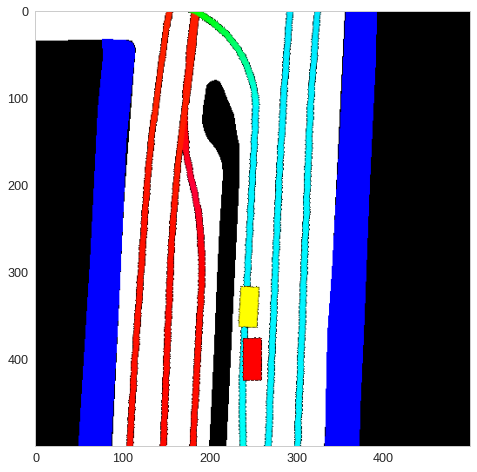

In [356]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

mini_train = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)

def update(i):
    instance_token, sample_token = mini_train[i].split("_")
    # annotation = helper.get_sample_annotation(instance_token, sample_token)
    img = mtp_input_representation.make_input_representation(instance_token, sample_token)
    plt.imshow(img)    

ani = FuncAnimation(plt.gcf(), update, frames=np.arange(50), blit=False, interval=50)
HTML(ani.to_html5_video())

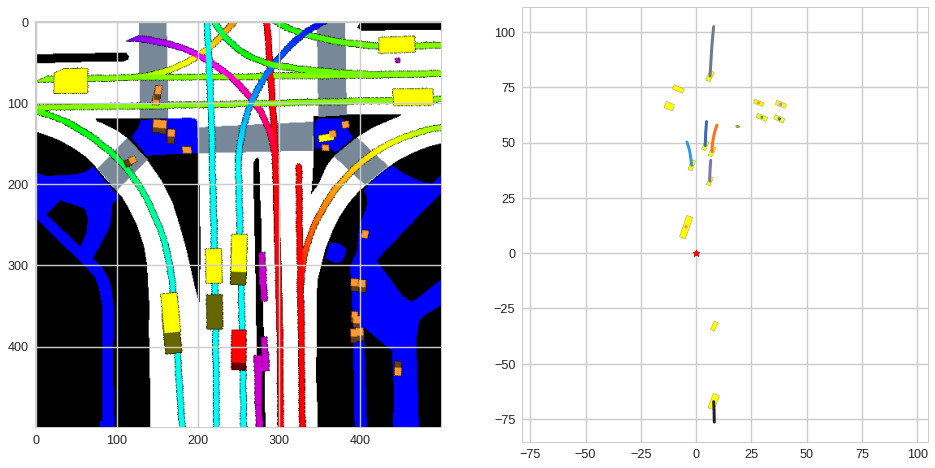

In [186]:
import matplotlib as mpl
import matplotlib.patches as patches
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
# cv_model = ConstantVelocityHeading(sec_from_now=3, helper=helper)
# physics_oracle = PhysicsOracle(sec_from_now=3, helper=helper)

instance_token, current_sample_token = mini_train[0].split("_")

fig, (ax1, ax2) = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = (16,8)

img = mtp_input_representation.make_input_representation(instance_token, current_sample_token)
ax1.imshow(img)

sample_anns = helper.get_annotations_for_sample(current_sample_token)
instance_tables = dict()
for ann in sample_anns:
    if ann['category_name'].startswith('vehicle'): # and int(ann['visibility_token']) > 3 and ann['num_lidar_pts'] > 10:
        instance_tables[ann['instance_token']] = ann
future_trajectories = dict()
for instance_token in instance_tables.keys():
    future_trajectory = helper.get_future_for_agent(instance_token, current_sample_token, seconds=3, in_agent_frame=False)
    # future_trajectory = cv_model(f"{instance_token}_{current_sample_token}").prediction[0]    
    # future_trajectory = physics_oracle(f"{instance_token}_{current_sample_token}").prediction[0]    
    if len(future_trajectory) != 0:
        future_trajectories[instance_token] = future_trajectory
ego_pos = nusc.get('ego_pose', nusc.get('sample_data', nusc.get('sample', current_sample_token)['data']['LIDAR_TOP'])['ego_pose_token'])

for instance_token, future_trajectory in future_trajectories.items():  
    w, l, h = instance_tables[instance_token]['size']
    _, _, yaw = euler_from_quaternion(*instance_tables[instance_token]['rotation'])      
    future_trajectory_local = global_to_local(ego_pos['translation'], ego_pos['rotation'], future_trajectory)  
    
    #Rotate rectangle patch object 
    point = np.array([[w/2,l/2],[-w/2,l/2],[-w/2, -l/2],[w/2,-l/2]])
    point = point.T
    point = np.vstack([point, np.ones_like(point[0])])
    yaw = yaw + np.pi / 2

    mat = np.array([[math.cos(yaw), -math.sin(yaw), future_trajectory_local[0][0]],
                    [math.sin(yaw), math.cos(yaw), future_trajectory_local[1][0]],
                    [0, 0, 1]])
    point = np.matmul(mat, point)
    point = point[:2].T
    rect = patches.Polygon(point, fill=True ,edgecolor='k', facecolor='yellow', ls='solid')
    
    ax2.scatter(x=0,y=0, marker='*', color='red')
    ax2.add_patch(rect)    
    ax2.plot(future_trajectory_local[0], future_trajectory_local[1], linewidth=3)    
    ax2.axis('equal')    

In [208]:
from math import sin, cos, acos, sqrt

def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = sqrt(mag2)
        v = tuple(n / mag for n in v)
    return np.array(v)

class Quaternion:

    def from_axisangle(theta, v):
        theta = theta
        v = normalize(v)

        new_quaternion = Quaternion()
        new_quaternion._axisangle_to_q(theta, v)
        return new_quaternion

    def from_value(value):
        new_quaternion = Quaternion()
        new_quaternion._val = value
        return new_quaternion

    def _axisangle_to_q(self, theta, v):
        x = v[0]
        y = v[1]
        z = v[2]

        w = cos(theta/2.)
        x = x * sin(theta/2.)
        y = y * sin(theta/2.)
        z = z * sin(theta/2.)

        self._val = np.array([w, x, y, z])

    def __mul__(self, b):

        if isinstance(b, Quaternion):
            return self._multiply_with_quaternion(b)
        elif isinstance(b, (list, tuple, np.ndarray)):
            if isinstance(b, np.ndarray) and len(b.shape) == 2:                                
                return np.array([self._multiply_with_vector(x) for x in b])
            else:
                if len(b) != 3:
                    raise Exception(f"Input vector has invalid length {len(b)}")            
                return self._multiply_with_vector(b)            
        else:
            raise Exception(f"Multiplication with unknown type {type(b)}")

    def _multiply_with_quaternion(self, q2):
        w1, x1, y1, z1 = self._val
        w2, x2, y2, z2 = q2._val
        w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
        x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
        y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
        z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2

        result = Quaternion.from_value(np.array((w, x, y, z)))
        return result

    def _multiply_with_vector(self, v):
        q2 = Quaternion.from_value(np.append((0.0), v))
        return (self * q2 * self.get_conjugate())._val[1:]

    def get_conjugate(self):
        w, x, y, z = self._val
        result = Quaternion.from_value(np.array((w, -x, -y, -z)))
        return result

    def __repr__(self):
        theta, v = self.get_axisangle()
        return f"((%.6f; %.6f, %.6f, %.6f))"%(theta, v[0], v[1], v[2])

    def get_axisangle(self):
        w, v = self._val[0], self._val[1:]
        theta = acos(w) * 2.0

        return theta, normalize(v)

    def tolist(self):
        return self._val.tolist()

    def vector_norm(self):
        w, v = self.get_axisangle()
        return np.linalg.norm(v)

In [240]:
x_axis_unit = (1, 0, 0)
y_axis_unit = (0, 1, 0)
z_axis_unit = (0, 0, 1)

r1 = Quaternion.from_axisangle(np.pi / 2, x_axis_unit)
r2 = Quaternion.from_axisangle(np.pi / 2, y_axis_unit)
r3 = Quaternion.from_axisangle(np.pi / 2, z_axis_unit)

# Quaternion - vector multiplication
v = r1 * y_axis_unit
v = r2 * v
v = r3 * v

print(v)

# Quaternion - quaternion multiplication
r_total = r3 * r2 * r1
v = r_total * y_axis_unit

print(v)

v = r_total * np.array([x_axis_unit, y_axis_unit, z_axis_unit])

print(v)

[0.00000000e+00 1.00000000e+00 2.22044605e-16]
[0.00000000e+00 1.00000000e+00 1.57009246e-16]
[[ 0.00000000e+00  1.57009246e-16 -1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.57009246e-16]
 [ 1.00000000e+00  0.00000000e+00 -3.08148791e-33]]


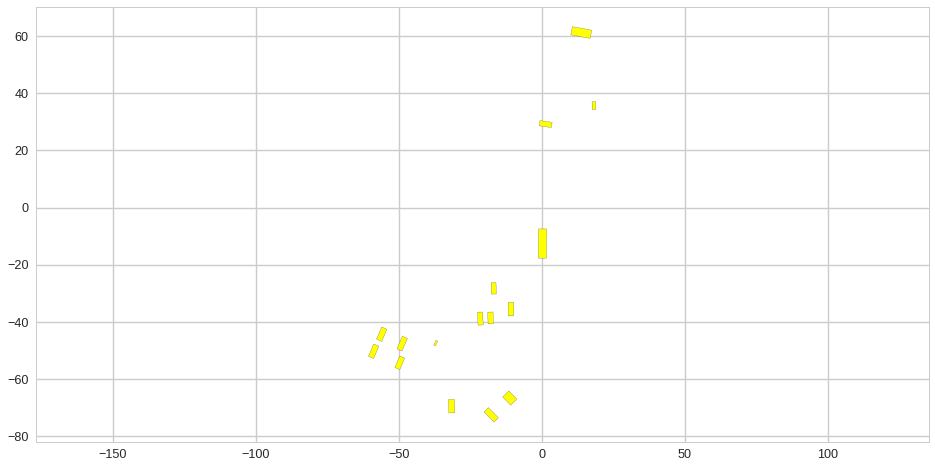

In [238]:
for instance_token, ann in instance_tables.items():
    w, l, h = ann['size']            
    point = np.array([[w/2,l/2,0],[-w/2,l/2,0],[-w/2,-l/2,0],[w/2,-l/2,0]])
    
    w, i, j, k = ann['rotation']
    rot1 = Quaternion.from_axisangle(w, (i,j,k))
    w, i, j, k = ego_pos['rotation']
    rot2 = Quaternion.from_axisangle(w, (i,j,k)).get_conjugate()
    r_total = rot2*rot1
    translation = np.array(ann['translation']) - np.array(ego_pos['translation'])      
    
    point = r_total*point + translation    
    point = point[:,:2]     
    
    ax = plt.gca()    
    rect = patches.Polygon(point, fill=True ,edgecolor='k', facecolor='yellow', ls='solid')    
    ax.add_patch(rect)    
    ax.axis('equal')    

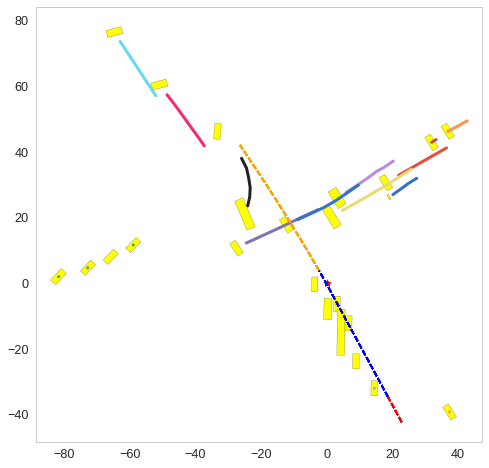

In [355]:
import matplotlib as mpl
import matplotlib.patches as patches
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils

# cv_model = ConstantVelocityHeading(sec_from_now=3, helper=helper)
# physics_oracle = PhysicsOracle(sec_from_now=3, helper=helper)

fig, ax2 = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['axes.grid'] = False

def update(i):
    instance_token, current_sample_token = mini_train[i].split("_")
    
    plt.cla()
    ax2 = plt.gca()
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # plt.rcParams['figure.figsize'] = (16,8)

    # img = mtp_input_representation.make_input_representation(instance_token, current_sample_token)
    # ax1.imshow(img)

    sample_anns = helper.get_annotations_for_sample(current_sample_token)
    instance_tables = dict()
    for ann in sample_anns:
        if ann['category_name'].startswith('vehicle'): # and int(ann['visibility_token']) > 3 and ann['num_lidar_pts'] > 10:
            instance_tables[ann['instance_token']] = ann
    future_trajectories = dict()
    for instance_token in instance_tables.keys():
        future_trajectory = helper.get_future_for_agent(instance_token, current_sample_token, seconds=3, in_agent_frame=False)
        # future_trajectory = cv_model(f"{instance_token}_{current_sample_token}").prediction[0]    
        # future_trajectory = physics_oracle(f"{instance_token}_{current_sample_token}").prediction[0]    
        if len(future_trajectory) != 0:
            future_trajectories[instance_token] = future_trajectory
    ego_pos = nusc.get('ego_pose', nusc.get('sample_data', nusc.get('sample', current_sample_token)['data']['LIDAR_TOP'])['ego_pose_token'])

    for instance_token, future_trajectory in future_trajectories.items():  
        w, i, j, k = ego_pos['rotation']
        ego_rot_inv = Quaternion.from_axisangle(w, (i,j,k)).get_conjugate()        
        ego_trans = np.array(ego_pos['translation'])
        future_trajectory = np.concatenate([future_trajectory, np.zeros(shape=(len(future_trajectory),1))],axis=1)
        future_trajectory_local = ego_rot_inv * (future_trajectory - ego_trans)

        ax2.scatter(x=0,y=0, marker='*', color='red')    
        ax2.plot(future_trajectory_local[:,0], future_trajectory_local[:,1], linewidth=3)    
        # ax2.scatter(x=ego_trans[0],y=ego_trans[1], marker='*', color='red')
        # ax2.plot(future_trajectory[:,0], future_trajectory[:,1], linewidth=3)    

        #Rotate rectangle patch object 
        w, l, h = instance_tables[instance_token]['size']
        point = np.array([[w/2,l/2,0],[-w/2,l/2,0],[-w/2,-l/2,0],[w/2,-l/2,0]])    
        w, i, j, k = instance_tables[instance_token]['rotation']
        inst_rot = Quaternion.from_axisangle(w, (i,j,k))
        inst_trans = np.array(instance_tables[instance_token]['translation'])

        point = inst_rot * point + inst_trans
        point = ego_rot_inv * (point - ego_trans)    
        point = point[:,:2]         
        rect = patches.Polygon(point, fill=True ,edgecolor='k', facecolor='yellow', ls='solid')

        ax2.add_patch(rect)        
        ax2.axis('equal')    

        map_name = nusc.get('log', nusc.get('scene',nusc.get('sample',current_sample_token)['scene_token'])['log_token'])['location']    
        nusc_map = NuScenesMap(map_name=map_name, dataroot=DATAROOT)
        closest_lane = nusc_map.get_closest_lane(ego_trans[0], ego_trans[1], radius=2)
        closest_lane_record = nusc_map.get_arcline_path(closest_lane)
        incoming_lanes = nusc_map.get_incoming_lane_ids(closest_lane)
        incoming_lane_records = {lane : nusc_map.get_arcline_path(lane) for lane in incoming_lanes}
        outgoing_lanes = nusc_map.get_outgoing_lane_ids(closest_lane)
        outgoing_lane_records = {lane : nusc_map.get_arcline_path(lane) for lane in outgoing_lanes}
        closest_lane_poses = ego_rot_inv * (np.array(arcline_path_utils.discretize_lane(closest_lane_record, resolution_meters=1)) - ego_trans)
        incoming_lane_poses = {lane: ego_rot_inv * (np.array(arcline_path_utils.discretize_lane(lane_record, resolution_meters=1)) - ego_trans) 
                               for lane, lane_record in incoming_lane_records.items()}
        outgoing_lane_poses = {lane: ego_rot_inv * (np.array(arcline_path_utils.discretize_lane(lane_record, resolution_meters=1)) - ego_trans)
                               for lane, lane_record in outgoing_lane_records.items()}

        plt.plot(closest_lane_poses[:,0], closest_lane_poses[:,1], color='blue', linestyle='dashed')
        for k, v in incoming_lane_poses.items():
            plt.plot(v[:,0], v[:,1], color='red', linestyle='dashed')
        for k, v in outgoing_lane_poses.items():
            plt.plot(v[:,0], v[:,1], color='orange', linestyle='dashed')
        
ani = FuncAnimation(fig, update, frames=np.arange(50), blit=False, interval=50)
HTML(ani.to_html5_video())